In [232]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [173]:
file = open("./dataset/scatter_ds1.d")

In [174]:
data = []
label = []

for line in file:
    line = line.strip().split(' ')
    data.append([float(line[0]),float(line[1])])
    label.append(int(line[2]))

In [175]:
data = np.array(data)
label = np.array(label)

In [176]:
print(data.shape)
print(label.shape)

(300, 2)
(300,)


In [188]:
def visualize(data,label,N_c):

    clusters = [[] for _ in range(N_c)]
    
    N = data.shape[0]
    for i in range(N):
        for c in range(N_c):
            if label[i] == c:
                clusters[c].append(data[i])
                
    plt.figure()
    colors = 'rgbycm'
    for c in range(N_c):
        clusters[c] = np.array(clusters[c])
        plt.scatter(clusters[c][:,0],clusters[c][:,1],c=colors[c])
    

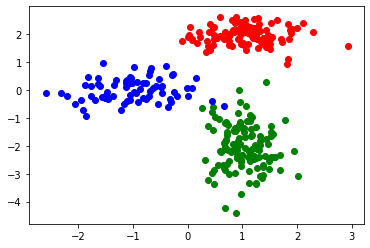

In [189]:
visualize(data,label,3)

In [178]:
file = open('./dataset/simil_ds1.d')

mat_simil = []

for line in file:
    line = line.strip().split(' ')
    mat_simil.append(list(float(line[i]) for i in range(len(line))))

mat_simil = np.array(mat_simil)

In [179]:
print(mat_simil.shape)

(300, 300)


In [286]:
class clustering:
    
    def __init__(self,simil,T,N_c,ε):
        
        self.simil = simil
        self.T = T
        self.N_c = N_c
        self.ε = ε
        
        '''initialize'''
        
        self.N = simil.shape[0]
        self.m = 0
        
        self.P_i = 1/self.N
        self.P_c = np.zeros(self.N_c)
        self.P_ci = np.zeros((self.N,self.N_c))
        self.P_ic = np.zeros((self.N_c,self.N))
        
        self.S_c = np.zeros(self.N_c)
        self.S_ci = np.zeros((self.N,self.N_c))

        '''set P(C|i) as a random (normalized) distribution'''
        
        for i in range(self.N): 
            r_list = np.array(list(np.random.random() for _ in range(self.N_c)))
            r_list = r_list/sum(r_list)
            self.P_ci[i] = r_list
        
        '''and update all the parameters with P(C|i)'''
        
        self.update_value()
        
        
    def fit(self):
        
        '''initialize a new matrix for P(m+1)(C|i)'''
        
        P_ci_new = np.zeros((self.N,self.N_c))
        
        stop = 0
        
        while stop == 0:
            
            '''compute P(m+1)(C|i) according to formula [7] in article'''
            
            for i in range(self.N):
                for c in range(self.N_c):
                    P_ci_new[i][c] = self.P_c[c]*np.exp((1/self.T) * (2*self.S_ci[i][c] - self.S_c[c]))
                P_ci_new[i] = P_ci_new[i]/sum(P_ci_new[i])
               
            self.m += 1
            stop = 1
            
            '''check if all the |P(m+1)(C|i) - P(m)(C|i)| <= ε'''
            
            for i in range(self.N):
                for c in range(self.N_c):
                    if abs(P_ci_new[i][c] - self.P_ci[i][c]) > self.ε:
                        stop = 0
                        continue
            
            '''update P(m)(C|i)'''
            
            for i in range(self.N):
                for c in range(self.N_c):
                    self.P_ci[i][c] = np.nan_to_num(P_ci_new[i][c]) #replace nan to  0 to avoid underflow

            '''and update all the parameters with new P(m)(C|i)'''
            
            self.update_value()
        
        print("Iteration times:",self.m)
    
    
    def predict(self):
        
        '''return the cluster with the highest probability P(C|i) as the cluster predicted'''
        
        predict_label = list(np.argmax(self.P_ci[i]) for i in range(self.N))
        
        return predict_label
    
    
    def parameters(self):
        
        '''compute <S> and return all the parameters necessary'''
        
        S = self.P_c.T @ self.S_c
        
        return S,self.S_c,self.S_ci,self.P_ci

        
    def update_value(self):
            
        '''compute P(C): P(c) = sum(P(C|i)*P(i))'''
        
        for c in range(self.N_c):
            self.P_c[c] = sum(self.P_ci[:,c]) * self.P_i
        
        '''compute P(i|C) according to Bayes' theorem'''
        
        for i in range(self.N_c):
            for j in range(self.N):
                self.P_ic[i][j] = self.P_ci[j][i] * self.P_i / self.P_c[i]
        
        '''compute S(C) according to formula [1] in article'''

        for c in range(self.N_c):
            for i in range(self.N):
                for j in range(self.N):
                    self.S_c[c] += self.P_ic[c][i] * self.P_ic[c][j] * self.simil[i][j]

        '''compute S(C;i) according to formula [6] in article'''

        for c in range(self.N_c):
            for i in range(self.N):
                for j in range(self.N):
                    self.S_ci[i][c] += self.P_ic[c][j] * self.simil[i][j]

                    
    def sort(self):

        '''sort the cluster according to the S(C)'''
        
        clusters_sorted = np.argsort(-self.S_c)
        cluster_dict = {}
        label = self.predict()
        
        '''build a library for the clusters sorted and their corresponding elements'''
        
        for c in clusters_sorted:
            for i,c_i in enumerate(label):
                if c_i == c:
                    cluster_dict.setdefault(c,[]).append(i)
        
        '''
        sort the elements according to the S(C;i)
        S(C;i): the similarity between i and the other elements in the same cluster
        '''
        
        element_list = []

        for c in cluster_dict.keys():
            S_ci_temp = []
            for i in cluster_dict[c]:
                S_ci_temp.append(self.S_ci[i][c])

            element_list.extend(list(np.array(cluster_dict[c])[np.argsort(-np.array(S_ci_temp))]))
        
        '''build an permutation matrix P and reorder the similarity matrix'''
        
        mat_P = np.zeros((self.N,self.N))

        for i,elem in enumerate(element_list):
            mat_P[elem][i] = 1
        
        mat_simil_sorted = mat_P.T @ self.simil @ mat_P
        
        '''return the similarity matrix reordered'''
        
        return mat_simil_sorted

In [276]:
cluster = clustering(mat_simil,0.1,5,0.01)

In [277]:
cluster.fit()

Iteration times: 20


In [278]:
predict_label = cluster.predict()
S,S_c,S_ci,P_ci,P_c = cluster.parameters()

In [279]:
print('S =',S)
print('S_c =',S_c)
print(P_ci)

S = -20.124664221281456
S_c = [-20.14596745 -18.000888   -21.79746813 -19.9506885  -22.26424338]
[[0.00000000e+000 0.00000000e+000 2.77610748e-218 0.00000000e+000
  1.00000000e+000]
 [0.00000000e+000 1.00000000e+000 5.61124743e-187 4.96622514e-057
  0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 4.06543075e-081 0.00000000e+000
  1.00000000e+000]
 [0.00000000e+000 1.00000000e+000 1.21150764e-201 4.10611991e-069
  0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 1.06035017e-161 0.00000000e+000
  0.00000000e+000]]


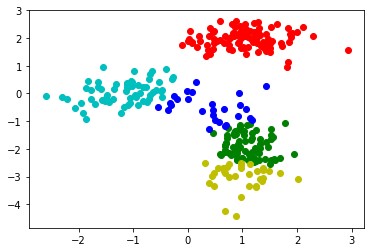

In [281]:
visualize(data,predict_label,5)

In [282]:
mat_simil_sorted = cluster.sort()
print(mat_simil_sorted.shape)

(300, 300)


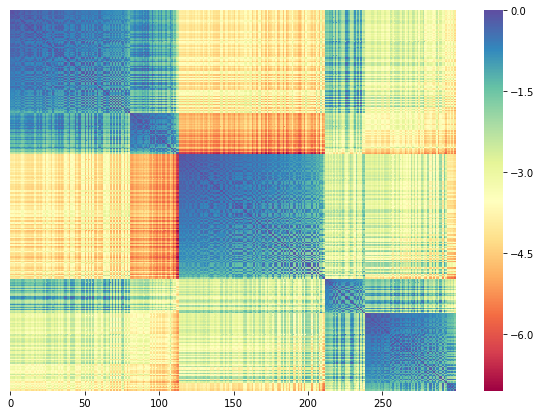

In [283]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted,xticklabels=50, yticklabels=False, cmap='Spectral')
plt.show()

In [284]:
file = open('./dataset/simil_ds2.d')

mat_simil1 = []

for line in file:
    line = line.strip().split(' ')
    mat_simil1.append(list(float(line[i]) for i in range(len(line))))

mat_simil1 = np.array(mat_simil1)

In [287]:
s_list = []
s_c_list = []
for c in range(2,10):
    cluster = clustering(mat_simil1,0.1,c,0.01)
    cluster.fit()
    S,S_c,_,_ = cluster.parameters()
    s_list.append(S)
    s_c_list.append(S_c)

Iteration times: 20
Iteration times: 14
Iteration times: 6
Iteration times: 25
Iteration times: 8
Iteration times: 19
Iteration times: 34
Iteration times: 27


In [288]:
'''Selon le resultat, 4 clusters sont présents'''
print(s_list) 

[-43.23111692347263, -30.059219152603994, -12.919088978992948, -30.398993028875008, -13.229351528598855, -24.891975480011567, -33.69732891042878, -28.878869595914722]


In [293]:
cluster = clustering(mat_simil1,0.1,4,0.01)
cluster.fit()
mat_simil_sorted = cluster.sort()
print(mat_simil_sorted.shape)

Iteration times: 10
(300, 300)


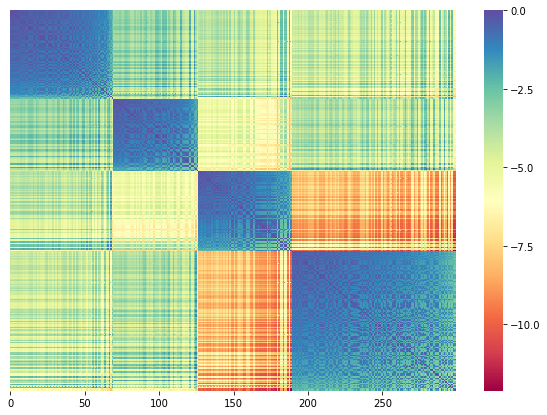

In [294]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted,xticklabels=50, yticklabels=False, cmap='Spectral')
plt.show()

## Dataset SP500

In [295]:
fileSP_simil = open('./dataset/SP500/mi_sp500.d')
fileSP_matType = open('./dataset/SP500/sp500_matType.d')

dataSP_simil = []
dataSP_matType = []

for line in fileSP_simil:
    line = line.strip().split(' ')
    dataSP_simil.append(list(float(line[i]) for i in range(len(line))))
    
for line in fileSP_matType:
    line = line.strip().split(' ')
    dataSP_matType.append(list(float(line[i]) for i in range(len(line))))
    
dataSP_simil = np.array(dataSP_simil)
dataSP_matType = np.array(dataSP_matType)

In [296]:
print(dataSP_simil.shape)
print(dataSP_matType.shape)

(501, 501)
(501, 208)


In [313]:
cluster_SP = clustering(dataSP_simil,0.05,15,0.01)

In [314]:
cluster_SP.fit()

Iteration times: 22


In [315]:
predict_label_SP = cluster_SP.predict()
S_SP,S_c_SP,S_ci_SP,P_ci_SP = cluster_SP.parameters()

In [316]:
print('S_SP =',S_SP)
print('S_c_SP =',S_c_SP)

S_SP = 4.33252269552838
S_c_SP = [4.24465401 2.53349048 3.67103083 6.45075829 4.95715861 3.54664671
 3.82909939 5.64042805 4.1587756  5.48635486 1.94279529 7.47403137
 5.46367924 2.98873578 4.40202314]


In [317]:
count = 0
for elem in P_ci_SP:
    for p in elem:
        if p >= 0.9:
            count += 1
            continue
percentage = count/P_ci_SP.shape[0]
print(percentage,count,P_ci_SP.shape[0])

1.0 501 501


In [318]:
print(P_ci_SP[:5])

[[6.09725571e-32 2.38191802e-38 9.35894659e-35 1.04256845e-54
  5.84387505e-78 1.23152182e-43 1.51179106e-41 1.00000000e+00
  3.96459746e-39 3.31771719e-43 1.69187925e-39 1.62992124e-32
  6.24732920e-32 3.82679261e-55 3.85027580e-32]
 [1.00441405e-29 3.39404383e-31 1.23285753e-38 1.62288962e-63
  1.17706598e-63 2.73639581e-44 4.61719697e-36 4.37768747e-22
  4.93791253e-37 1.34970818e-37 3.70004547e-32 3.15349828e-35
  6.60031437e-33 1.98843333e-38 1.00000000e+00]
 [3.94905710e-26 1.00000000e+00 2.79600740e-32 3.94604784e-57
  8.74729804e-48 1.69113161e-34 1.08475078e-34 9.34090607e-38
  7.17545113e-31 3.19597572e-33 1.01324389e-17 5.62886658e-48
  1.63851480e-38 1.79279494e-26 1.52844386e-29]
 [3.01451460e-19 1.19283396e-12 1.23291311e-15 1.43513587e-39
  1.29523365e-36 1.59893785e-19 7.14470699e-19 4.36102542e-21
  1.20597794e-17 1.48840725e-30 1.00000000e+00 7.52483181e-42
  9.28504434e-25 1.82662911e-21 5.69056954e-22]
 [1.14947982e-37 9.19698891e-32 1.06737057e-34 1.12436539e-61
  

In [319]:
mat_simil_sorted_SP = cluster_SP.sort()

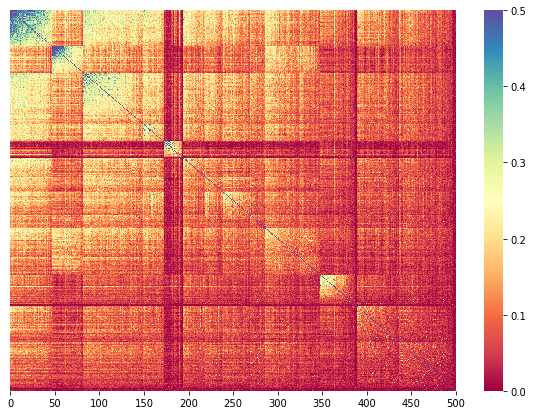

In [320]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted_SP,xticklabels=50, yticklabels=False,vmin=0, vmax=0.5, cmap='Spectral')
plt.show()

## Dataset Movie

In [100]:
fileMovie_simil = open('./dataset/MOVIES/mi_movie.d')
fileMovie_matType = open('./dataset/MOVIES/movie_labels.d')

dataMovie_simil = []
dataMovie_matType = []

for line in fileMovie_simil:
    line = line.strip().split(' ')
    dataMovie_simil.append(list(float(line[i]) for i in range(len(line))))
    
for line in fileMovie_matType:
    line = line.strip().split(' ')
    dataMovie_matType.append(list(float(line[i]) for i in range(len(line))))
    
dataMovie_simil = np.array(dataMovie_simil)
dataMovie_matType = np.array(dataMovie_matType)

In [101]:
print(dataMovie_simil.shape)
print(dataMovie_matType.shape)

(500, 500)
(500, 10)


In [102]:
print(dataMovie_matType[0])

[1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [103]:
cluster_Movie = clustering(dataMovie_simil,0.05,10,0.01)
cluster_Movie.fit()

Iteration times: 20


In [104]:
predict_label_Movie = cluster_Movie.predict()
S_Movie,S_c_Movie,S_ci_Movie,P_ci_Movie = cluster_Movie.parameters()

In [105]:
print('S_SP =',S_Movie)
print('S_c_SP =',S_c_Movie)

S_SP = 3.1451809029014837
S_c_SP = [2.68524853 3.80397697 2.61784929 1.61949862 4.0834567  2.99454443
 5.37215211 3.2453088  2.15892578 4.90706618]


In [106]:
mat_simil_sorted_Movie = cluster_Movie.sort()

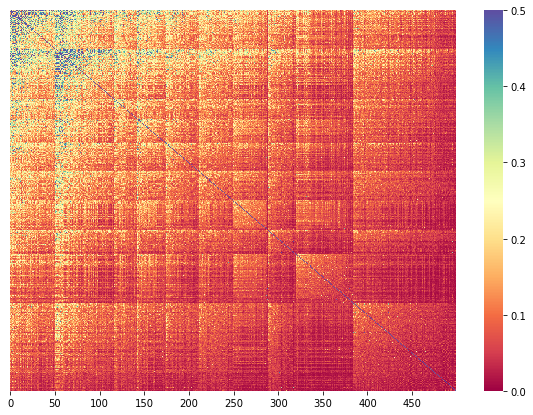

In [109]:
plt.figure(figsize=(10,7))
ax = sns.heatmap(mat_simil_sorted_Movie,xticklabels=50, yticklabels=False,vmin=0, vmax=0.5, cmap='Spectral')
plt.show()